In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
import pandas as pd
import numpy as np
import random
from datetime import date, timedelta

# Generate dummy stock price data
num_days = 365  # Number of days of historical data
start_date = date(2022, 1, 1)  # Start date

# Create a date range
date_range = [start_date + timedelta(days=i) for i in range(num_days)]

# Generate random stock prices
stock_prices = [100.0]  # Initial price
for _ in range(1, num_days):
    price_change = random.uniform(-5, 5)  # Random daily price change between -5 and 5
    new_price = stock_prices[-1] + price_change
    stock_prices.append(max(new_price, 0.1))  # Ensure prices are not negative

# Create a DataFrame
df = pd.DataFrame({'Date': date_range, 'Close': stock_prices})

# Save the DataFrame to a CSV file
df.to_csv('stock_prices.csv', index=False)


In [6]:

# Load the historical stock price data (replace 'your_data.csv' with your data file)
df = pd.read_csv('stock_prices.csv')

# Choose the column containing stock prices (e.g., 'Close' for closing prices)
price_column = 'Close'
df = df[[price_column]]

In [7]:

# Normalize the data to the range [0, 1] using Min-Max scaling
scaler = MinMaxScaler()
df[price_column] = scaler.fit_transform(np.array(df[price_column]).reshape(-1, 1))


In [8]:
# Define a function to create the input sequences and labels for LSTM training
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [9]:
# Define hyperparameters
seq_length = 20  # Length of input sequences
train_test_split = 0.8  # Percentage of data for training (the rest is for testing)

# Create sequences and labels
sequences, labels = create_sequences(df.values, seq_length)


In [10]:


# Split the data into training and testing sets
split_index = int(train_test_split * len(sequences))
X_train, y_train = sequences[:split_index], labels[:split_index]
X_test, y_test = sequences[split_index:], labels[split_index:]

# Build an LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=5, verbose=1)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to the original scale
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

Epoch 1/50
7/7 [==============================] - 3s 63ms/step - loss: 0.3041 - val_loss: 0.2527
Epoch 2/50
7/7 [==============================] - 0s 18ms/step - loss: 0.1932 - val_loss: 0.1390
Epoch 3/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0839 - val_loss: 0.0236
Epoch 4/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0323 - val_loss: 0.0059
Epoch 5/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0252 - val_loss: 0.0170
Epoch 6/50
7/7 [==============================] - 0s 23ms/step - loss: 0.0260 - val_loss: 0.0184
Epoch 7/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0233 - val_loss: 0.0079
Epoch 8/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0216 - val_loss: 0.0082
Epoch 9/50
7/7 [==============================] - 0s 30ms/step - loss: 0.0207 - val_loss: 0.0103
Epoch 9: early stopping
3/3 [==============================] - 0s 6ms/step


Root Mean Squared Error (RMSE): 6.47


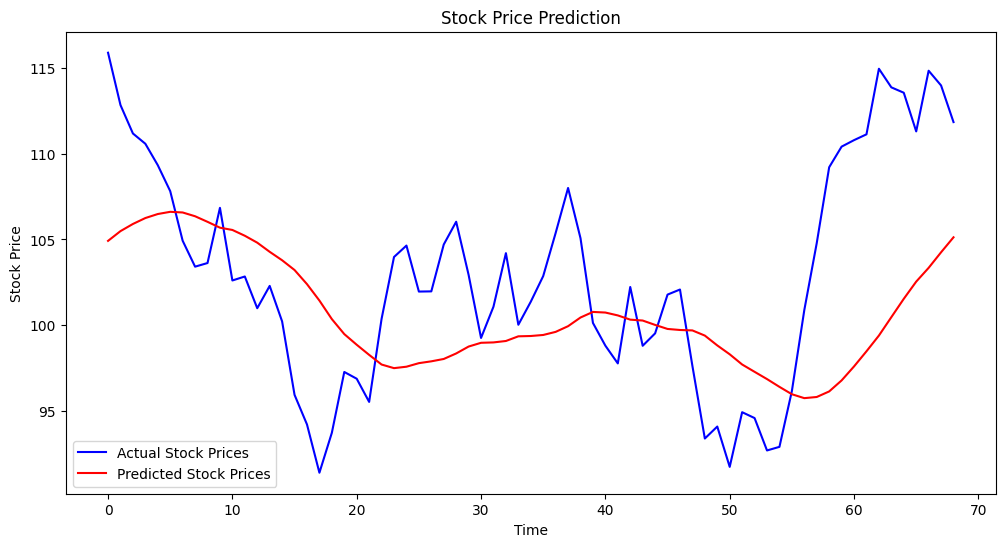

In [12]:
# Calculate the root mean squared error (RMSE) as a performance metric
rmse = sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Stock Prices', color='blue')
plt.plot(predictions, label='Predicted Stock Prices', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
